In [8]:
import pandas as pd 
import numpy as np
import warnings

In [3]:
warnings.filterwarnings(action='ignore')

In [6]:
x_df = pd.read_csv('x_df.csv')
x_df = x_df.iloc[:, 1:]

In [9]:
y_df_binarized = np.load('y_df_binarized.npy')

In [12]:
full_df = x_df
full_df['dna'] = y_df_binarized

In [13]:
synthetic_data = pd.read_csv("Synthetic_data(Gaussian Copula).csv")
synthetic_data = synthetic_data.iloc[:, 1:]

In [15]:
synthetic_data_1 = synthetic_data[synthetic_data['dna'] == 1]

In [16]:
df_0 = full_df[full_df['dna'] == 0].sample(n = 30, random_state=42)
df_1 = full_df[full_df['dna'] == 1].sample(n = 30, random_state=42)

result_df = pd.concat([df_0, df_1])

full_df = full_df.drop(result_df.index)

In [18]:
combined_data = pd.concat([full_df, synthetic_data_1], axis=0)

In [22]:
from sklearn.model_selection import train_test_split
from collections import Counter

x_df_s = combined_data.drop(columns='dna')
y_df_s = combined_data['dna']


X_train, X_test, y_train, y_test = train_test_split(x_df_s, y_df_s, stratify=y_df_s, test_size=0.15, random_state=42)


y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

print(Counter(y_train))
print(Counter(y_test))

Counter({1: 241, 0: 235})
Counter({1: 43, 0: 41})


In [27]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import f1_score, classification_report, roc_auc_score


# Class weight Setting
class_weight = {0: 2, 1: 1.7}

# SVM Model Setting
svm_model = SVC(random_state=42, class_weight=class_weight)

# SVM Parmeter Setting
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly']
}

# Best Parameter Searching
results = {}
result = {}

# Stratified K-Fold Setting
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Training SVM...")
grid_search = GridSearchCV(estimator=svm_model, param_grid=svm_param_grid, cv=stratified_kfold, scoring='roc_auc_ovr', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Parameters & 5 Fold-cross validation
cv_results = grid_search.cv_results_

fold_f1_scores = []
for i in range(5):
    print(f'Fold {i+1} Training ................')

print(f"Best Parameters for SVM:")
print(grid_search.best_params_)

# Prediction with best estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# AUC ROC Calculation
auc_roc = roc_auc_score(y_test, best_model.decision_function(X_test))

# Assessment score present
print(f"\nTest Result for SVM:")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate classification report as a dictionary
report = classification_report(y_test, y_pred, output_dict=True)

# Store result 
result['SVM'] = {
    'f1_score': report['weighted avg']['f1-score'],
    'accuracy': report['accuracy']
}

# Final Results Reporting
print("\nSVM Test Results:")
print(f"SVM F1-score : {result['SVM']['f1_score']: .4f}, AUC ROC : {auc_roc:.4f}, Accuracy : {result['SVM']['accuracy']:.4f}")

Training SVM...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fold 1 Training ................
Fold 2 Training ................
Fold 3 Training ................
Fold 4 Training ................
Fold 5 Training ................
Best Parameters for SVM:
{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

Test Result for SVM:
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.78      0.73        41
           1       0.76      0.65      0.70        43

    accuracy                           0.71        84
   macro avg       0.72      0.72      0.71        84
weighted avg       0.72      0.71      0.71        84


SVM Test Results:
SVM F1-score :  0.7133, AUC ROC : 0.7930, Accuracy : 0.7143


In [31]:
y_pred = grid_search.best_estimator_.predict(result_df.drop(columns = 'dna'))

print(classification_report(result_df['dna'], y_pred))

              precision    recall  f1-score   support

           0       0.88      0.77      0.82        30
           1       0.79      0.90      0.84        30

    accuracy                           0.83        60
   macro avg       0.84      0.83      0.83        60
weighted avg       0.84      0.83      0.83        60



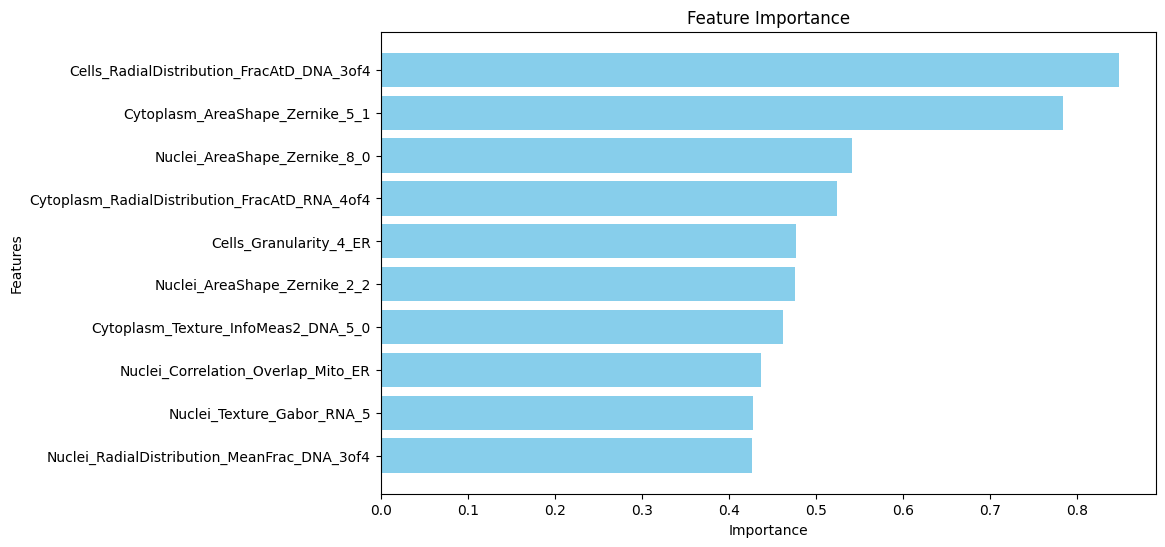

In [48]:
import matplotlib.pyplot as plt

importance = np.abs(best_model.coef_[0])


features = X_train.columns
feature_importance = pd.DataFrame({
    'Feature' : features,
    'Importance' : importance
})


feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'].head(10), feature_importance['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [51]:
cpg = pd.read_csv('x_val_df.csv')
cpg = cpg.iloc[:, 1:]

In [53]:
y_pred_1 = best_model.predict(cpg)

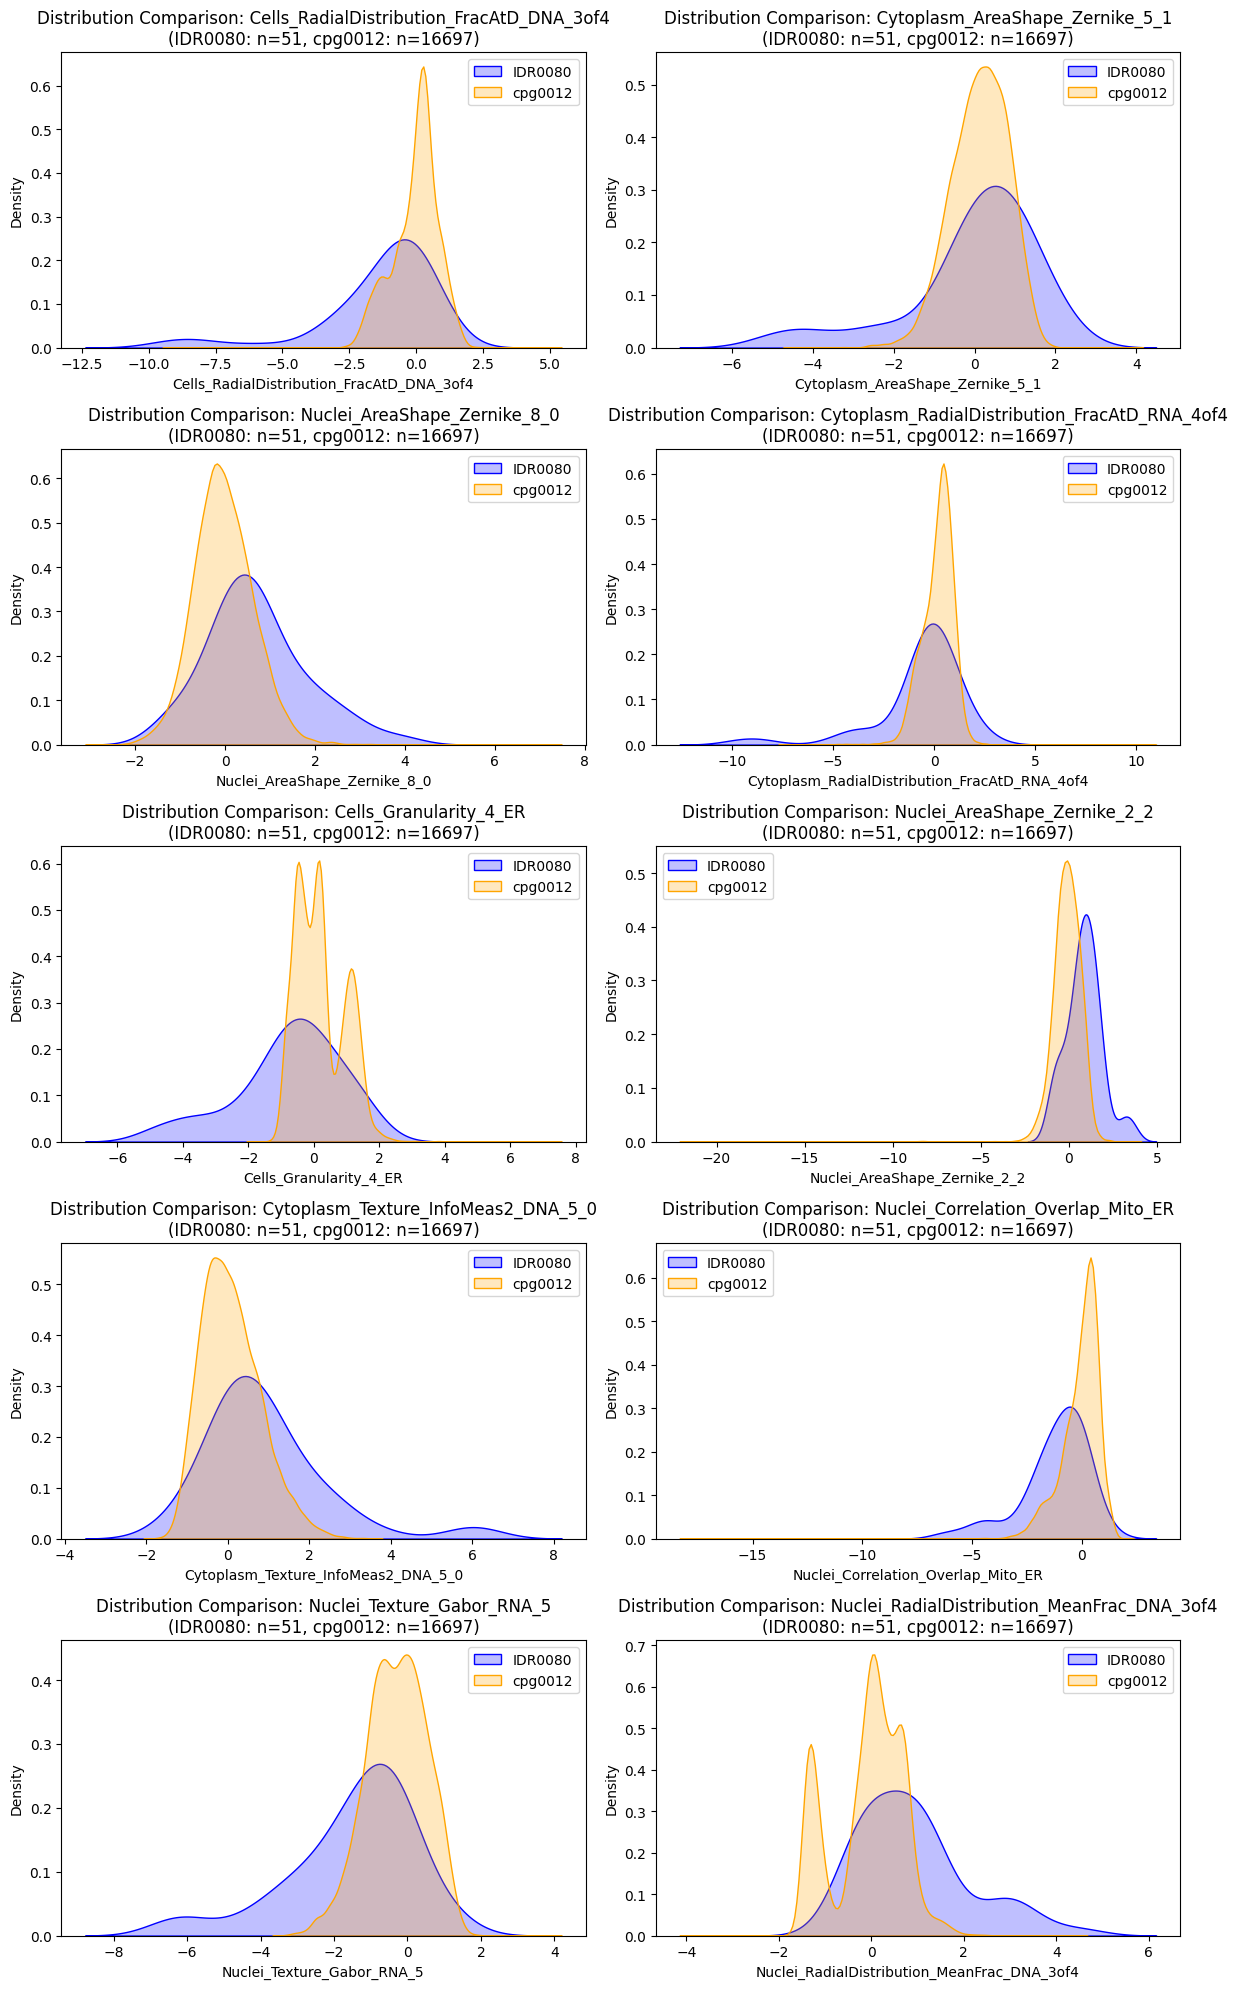

In [205]:
import seaborn as sns

comp_df = x_df
comp_df['dna'] = y_df_binarized


top_features = feature_importance['Feature'].head(10).to_list()


data_1 = comp_df[comp_df['dna'] == 1]
#data_2 = comp_df[comp_df['dna'] == 0]
data_2 = cpg
data_2['dna'] = y_pred_1
data_2 = data_2[data_2['dna'] == 0]




fig, axes = plt.subplots(5, 2, figsize=(12, 20))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    sns.kdeplot(data_1[feature], label='IDR0080', ax=axes[i], color='blue', shade=True)
    sns.kdeplot(data_2[feature], label='cpg0012', ax=axes[i], color='orange', shade=True)
    axes[i].set_title(f'Distribution Comparison: {feature}\n(IDR0080: n={len(data_1)}, cpg0012: n={len(data_2)})')
    #axes[i].set_title(f'Distribution Comparison: {feature}')
    axes[i].legend()


plt.tight_layout()
plt.show()

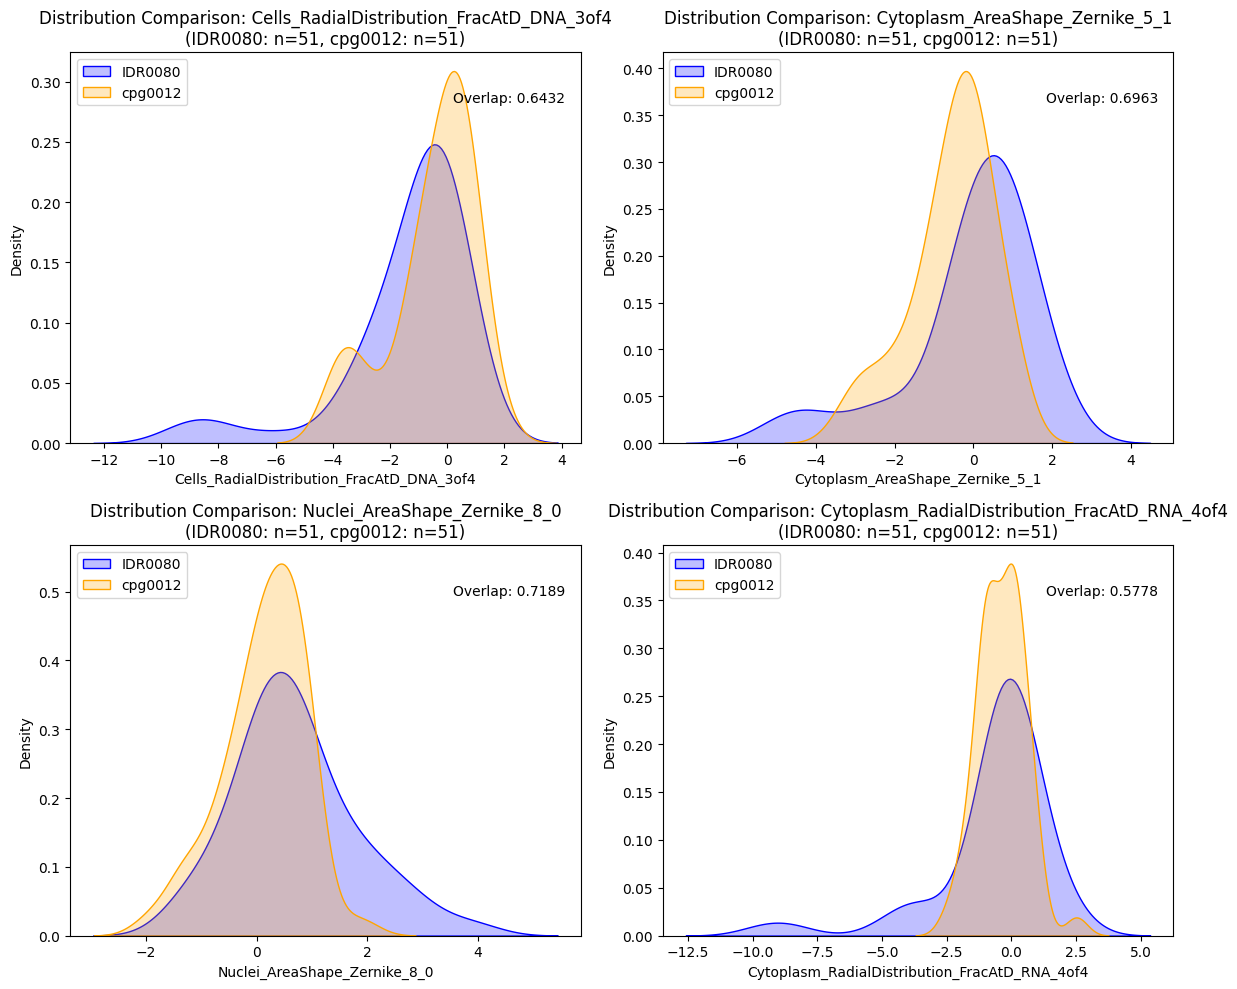

In [210]:
import seaborn as sns
from scipy.stats import gaussian_kde

np.random.seed(42)

def calculate_overlap(data_1, data_2, feature):
    '''Calculate KDE & Overlap Surface'''
    kde_1 = gaussian_kde(data_1[feature], bw_method=1.5)
    kde_2 = gaussian_kde(data_2[feature], bw_method=1.5)

    x_vals = np.linspace(min(data_1[feature].min(), data_2[feature].min()),
                         max(data_1[feature].max(), data_2[feature].max()), 1000)

    
    kde_1_vals = kde_1(x_vals)
    kde_2_vals = kde_2(x_vals)

    # Overlap area calculation
    overlap_area = np.sum(np.minimum(kde_1_vals, kde_2_vals)) * (x_vals[1] - x_vals[0])

    return overlap_area



top_features = feature_importance['Feature'].head(4).to_list()


data_1 = comp_df[comp_df['dna'] == 1]
data_2 = cpg
data_2['dna'] = y_pred_1
data_2 = data_2[data_2['dna'] == 1]


# Under Sampling
min_len = min(len(data_1), len(data_2))


data_1_sampled = data_1.sample(n=min_len, random_state=42)
data_2_sampled = data_2.sample(n=min_len, random_state=42)

# KDE Plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    sns.kdeplot(data_1_sampled[feature], label='IDR0080', ax=axes[i], color='blue', shade=True)
    sns.kdeplot(data_2_sampled[feature], label='cpg0012', ax=axes[i], color='orange', shade=True)

    overlap = calculate_overlap(data_1_sampled, data_2_sampled, feature)


    axes[i].set_title(f'Distribution Comparison: {feature}\n(IDR0080: n={len(data_1_sampled)}, cpg0012: n={len(data_2_sampled)})')
    axes[i].legend()

    axes[i].text(0.75, 0.9, f'Overlap: {overlap:.4f}', transform=axes[i].transAxes, fontsize=10, verticalalignment='top', color='black')

plt.tight_layout()
plt.show()


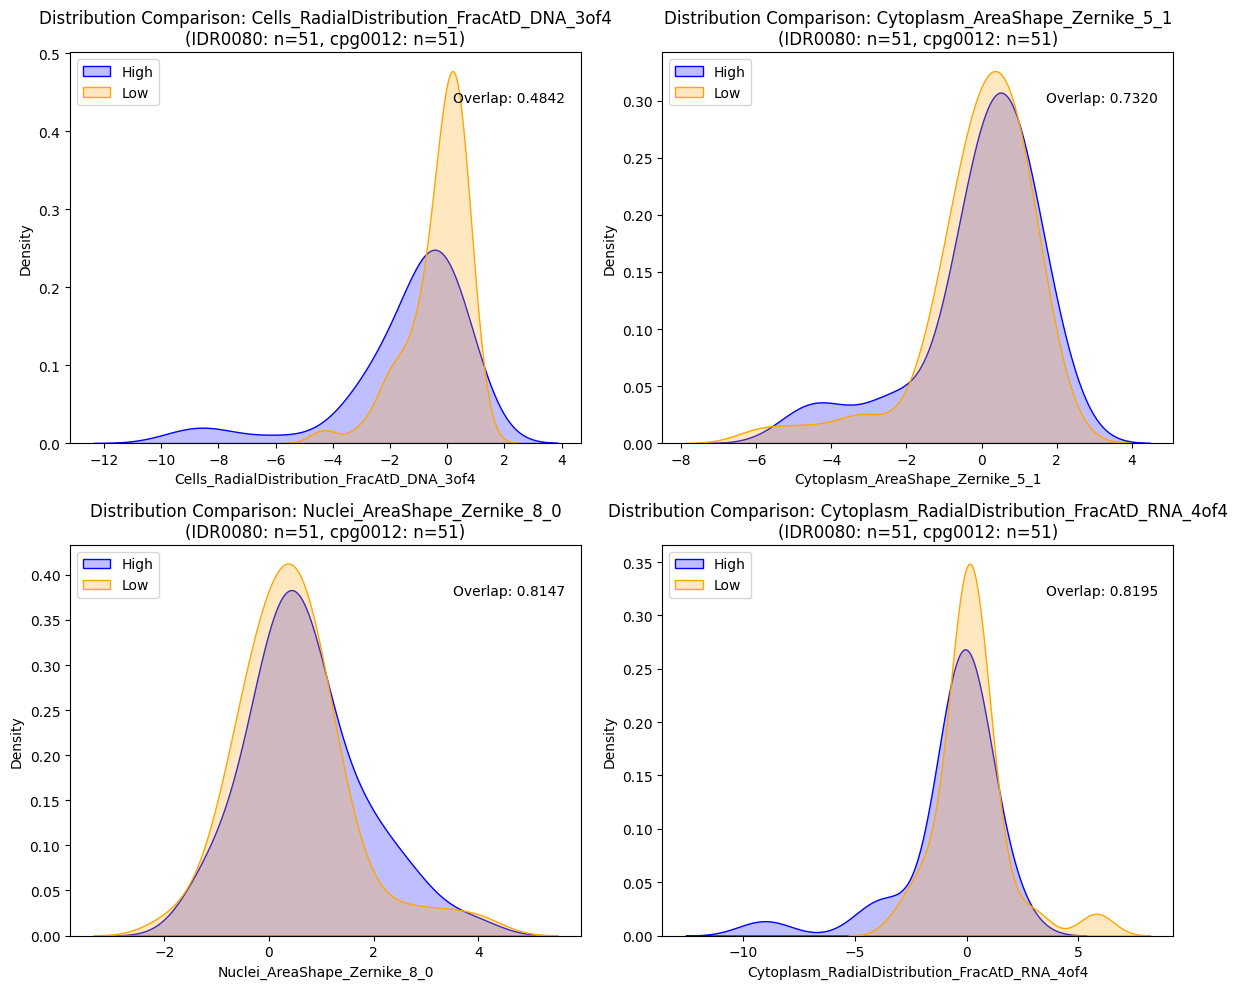

In [213]:
top_features = feature_importance['Feature'].head(4).to_list()


data_1 = comp_df[comp_df['dna'] == 1]
data_2 = comp_df[comp_df['dna'] == 0]
#data_2 = cpg
#data_2['dna'] = y_pred_1
#data_2 = data_2[data_2['dna'] == 1]


# Under Sampling
min_len = min(len(data_1), len(data_2))


data_1_sampled = data_1.sample(n=min_len, random_state=42)
data_2_sampled = data_2.sample(n=min_len, random_state=42)

# KDE Plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    sns.kdeplot(data_1_sampled[feature], label='High', ax=axes[i], color='blue', shade=True)
    sns.kdeplot(data_2_sampled[feature], label='Low', ax=axes[i], color='orange', shade=True)

    overlap = calculate_overlap(data_1_sampled, data_2_sampled, feature)


    axes[i].set_title(f'Distribution Comparison: {feature}\n(IDR0080: n={len(data_1_sampled)}, cpg0012: n={len(data_2_sampled)})')
    axes[i].legend()

    axes[i].text(0.75, 0.9, f'Overlap: {overlap:.4f}', transform=axes[i].transAxes, fontsize=10, verticalalignment='top', color='black')

plt.tight_layout()
plt.show()
